In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [2]:
data = np.load('../datasets/final_edges.dump', allow_pickle= True)

In [3]:
smiles = []
for i in data:
    smiles.append(i[0])
    smiles.append(i[1])
    

In [4]:
smiles = np.array(list(set(smiles)))

In [5]:
import networkx as nx

In [6]:
from karateclub import DeepWalk

In [7]:
G = nx.Graph()

In [8]:
obj = []
for i in tqdm(data):
    if i[2] == '1':
        id1 = np.where
        obj.append((np.where(smiles == i[0])[0][0],np.where(smiles == i[1])[0][0]) )

  0%|          | 0/87153 [00:00<?, ?it/s]

In [9]:
G.add_edges_from(obj)

In [10]:
model = DeepWalk()
model.fit(G)
embedding = model.get_embedding()

In [11]:
Nodes = np.array(G.nodes())

In [134]:
len(G.nodes())

418

In [12]:
from rdkit import Chem
import rdkit
from rdkit.Chem import AllChem

In [58]:
graph_embeds_data = []
fingerprint_data = []
for i in tqdm(data):
    graph_embeds_data.append([
                     np.concatenate((embedding[np.where(smiles == i[0])[0][0]], 
                                     embedding[np.where(smiles == i[1])[0][0]] )), i[2] ])
    
    mol1 = Chem.MolFromSmiles(i[0])
    mol2 = Chem.MolFromSmiles(i[1])
    fp1 = np.array(rdkit.Chem.RDKFingerprint(mol1, maxPath=7, fpSize=512), dtype=object)
    fp2 = np.array(rdkit.Chem.RDKFingerprint(mol2, maxPath=7, fpSize=512), dtype=object)
    fingerprint_data.append([
        np.concatenate(( fp1, fp2)), i[2]
    ])

  0%|          | 0/87153 [00:00<?, ?it/s]

In [59]:
fingerprint_data = np.array(fingerprint_data, dtype=object)
graph_embeds_data = np.array(graph_embeds_data)
fingerprint_data= np.array(fingerprint_data)

/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [60]:
graph_embeds_data.shape

(87153, 2)

In [15]:
# len(fingerprint_data[0][0])

In [61]:
final_data = []
for i in range(len(fingerprint_data)):
    final_data.append([np.concatenate((fingerprint_data[i][0], graph_embeds_data[i][0])), fingerprint_data[i][1]])

In [62]:
final_data = np.array(final_data)

/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [291]:
X = []
y = []
for i in tqdm(fingerprint_data):
    X.append(i[0])
    y.append(i[1])

  0%|          | 0/87153 [00:00<?, ?it/s]

In [292]:
X = np.array(X)
y = np.array(y)

In [293]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [294]:
X_train.shape

(69722, 1024)

In [295]:
y_train.shape

(69722,)

In [296]:
from sklearn.manifold import TSNE

In [297]:
X_train

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 0, 0, ..., 1, 1, 1]], dtype=object)

In [298]:
X_train = np.asarray(X_train, dtype='float64')

In [299]:
import seaborn as sns

In [304]:
tsne = TSNE(n_components=3)
embeds = tsne.fit_transform(X_train[:10000])
df = pd.DataFrame(embeds, columns=['x','y','z'])
df['b'] = y_train[:10000]


AttributeError: 'PathCollection' object has no property 'z'

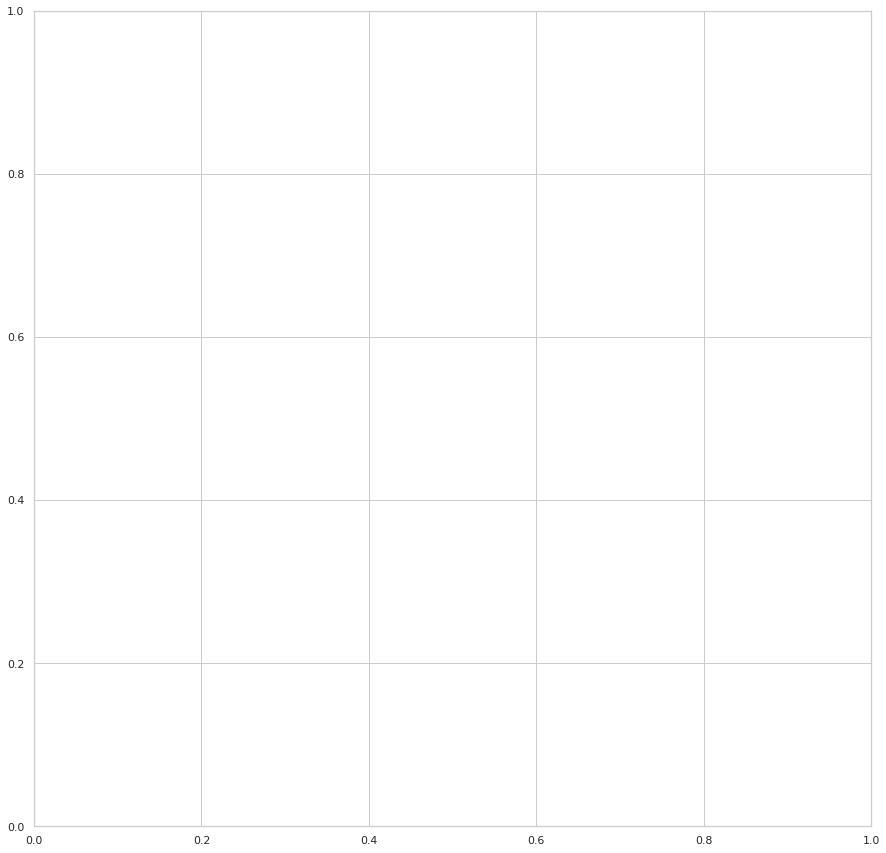

In [307]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style("whitegrid")
sns.scatterplot(data=df, x='x', y='y', z='z', s=70 ,hue='b',alpha=0.5, projection='3d')

In [314]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

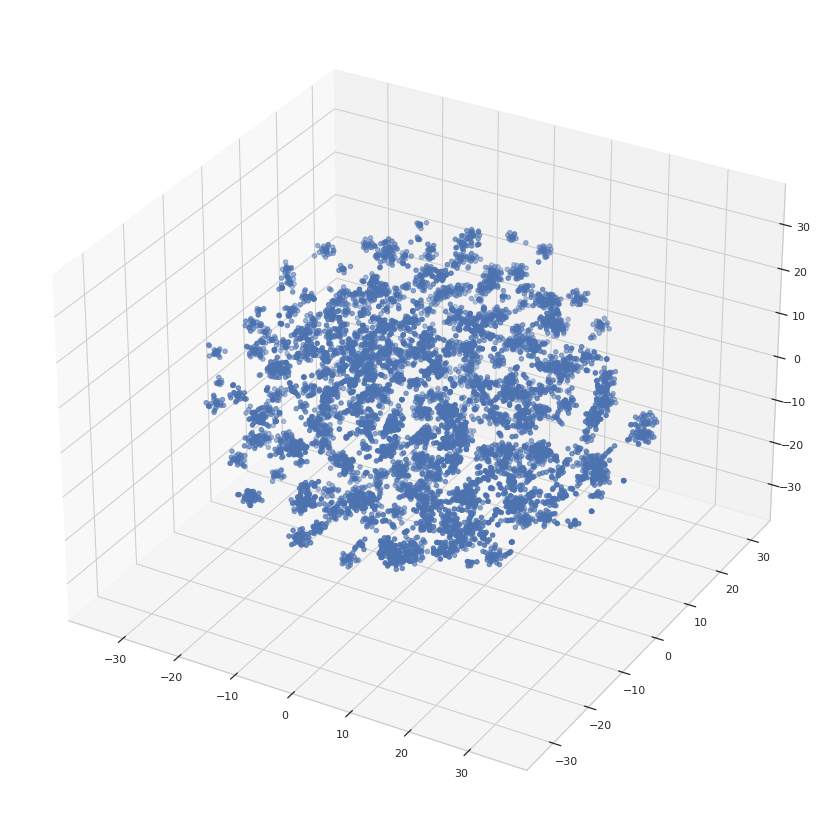

In [319]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['x']
y = df['y']
z = df['z']
b = df['b']
ax.scatter(x, y, z)

plt.show()

In [84]:
!pip install Node2Vec
from node2vec import Node2Vec


In [200]:
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/418 [00:00<?, ?it/s]

In [201]:
model = node2vec.fit(window=10, min_count=1, batch_words=4) 

In [202]:
from node2vec.edges import HadamardEmbedder, AverageEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [203]:
edges_kv = edges_embs.as_keyed_vectors()

Generating edge features: 100%|██████████| 87571/87571.0 [00:00<00:00, 194258.96it/s]


In [240]:
edges_embeds = []
for i in G.nodes():
    for j in G.nodes():
        if i != j:
            if (i,j) in G.edges():
                edges_embeds.append([edges_embs[(str(i),str(j))], 1])
            else:
                edges_embeds.append([edges_embs[(str(i),str(j))], 0])


In [241]:
edges_embeds = np.array(edges_embeds, dtype=object)

In [242]:
edges_embeds.shape

(174306, 2)

In [244]:
ls = []
for i in edges_embeds:
    ls.append(np.array(i[0], dtype='float64'))
ls= np.array(ls)  

In [246]:
ls.shape

(174306, 128)

<AxesSubplot:xlabel='x', ylabel='y'>

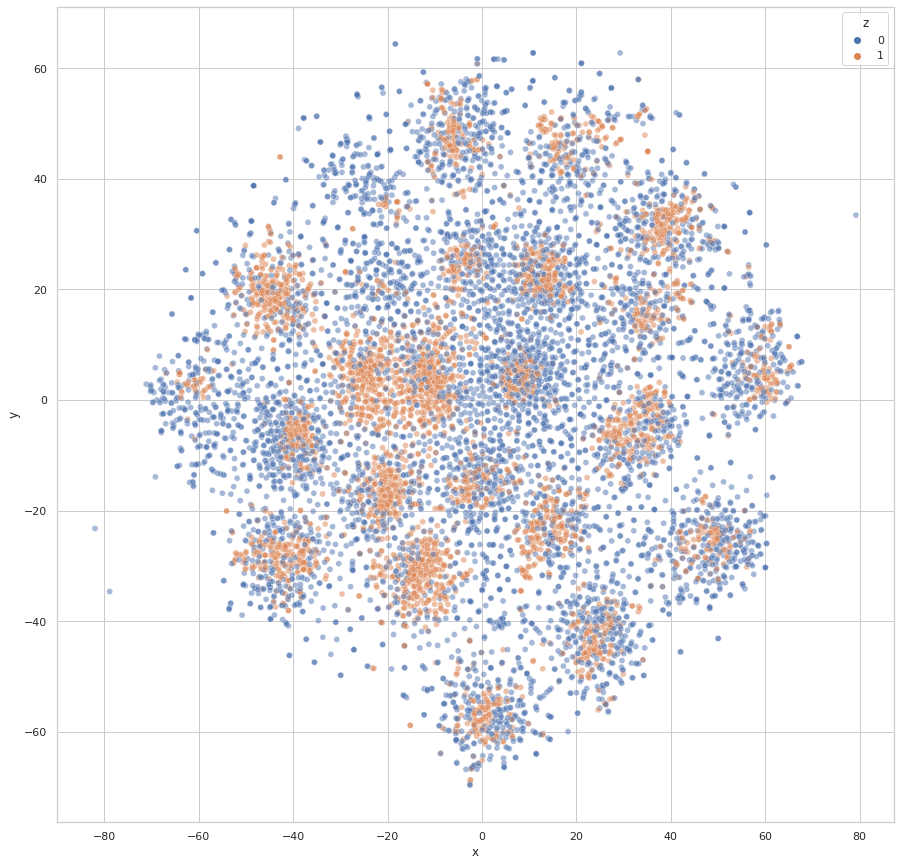

In [303]:
tsne = TSNE(n_components=2)
embeds = tsne.fit_transform(ls[:10000])
df = pd.DataFrame(embeds, columns=['x','y'])
df['z'] = edges_embeds[:10000,1]
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style("whitegrid")
sns.scatterplot(data=df, x='x', y='y',  hue='z',alpha=0.5)

In [252]:
embeds

array([[ -6.879256 ,   4.5833325],
       [ 15.425246 ,   4.123696 ],
       [  2.062808 ,  -1.405429 ],
       ...,
       [  8.820583 , -14.561386 ],
       [  5.486296 , -20.218956 ],
       [ 12.260191 ,  -9.742754 ]], dtype=float32)

In [34]:
from sklearn.ensemble import RandomForestClassifier
reg_rf = RandomForestClassifier()
reg_rf.fit(X_train, y_train)
y_pred = reg_rf.predict(X_test)

In [35]:
from sklearn import metrics

In [36]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11650
           1       0.88      0.80      0.84      5781

    accuracy                           0.90     17431
   macro avg       0.89      0.87      0.88     17431
weighted avg       0.90      0.90      0.89     17431



In [37]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))


roc_auc_score:  0.8710804596677142


/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [38]:
print("f1 score: ", metrics.f1_score(y_test, y_pred , pos_label='1'))

f1 score:  0.8355233348436791


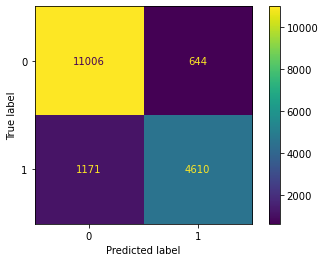

In [39]:
metrics.plot_confusion_matrix(reg_rf, X_test, y_test)